In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
dataset = torchvision.datasets.CIFAR10(root='data/',download=True,transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4,padding_mode='reflect'), # augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # CxHxW
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

test_dataset = torchvision.datasets.CIFAR10(root='data/',train = False,download=True,transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4,padding_mode='reflect'), # augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # CxHxW
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
val_ratio = 0.2
train_dataset, val_dataset = random_split(dataset,[int((1-val_ratio)*len(dataset)), int(val_ratio*len(dataset))])
batch_size =  32 #higher batch size is better
train_dl = DataLoader(train_dataset,batch_size,shuffle=True,pin_memory=True)
val_dl = DataLoader(val_dataset,batch_size,shuffle=True,pin_memory=True)
test_dl = DataLoader(test_dataset,batch_size,pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


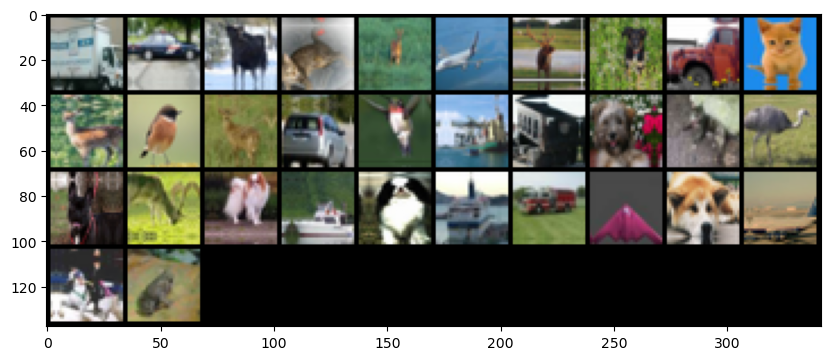

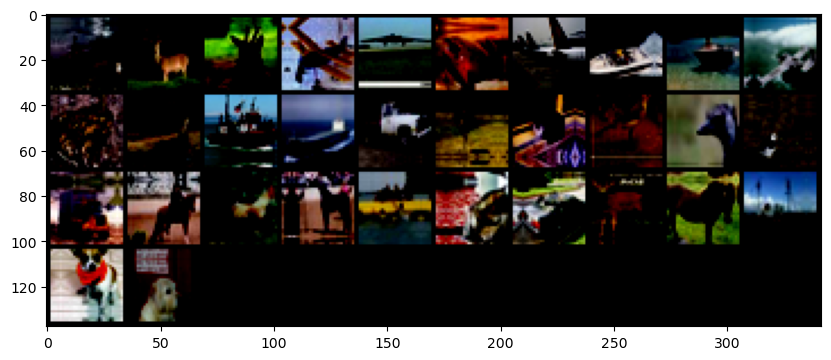

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def denormalize(images,means,std_div):
  means = torch.tensor(means).reshape(1,3,1,1)
  std_div = torch.tensor(std_div).reshape(1,3,1,1)
  return images*std_div + means

def show_preview(dl,normalized):
  for images,labels in dl:
    fig, ax = plt.subplots(figsize=(10,10))
    if(normalized):
      images = denormalize(images,(0.5,0.5,0.5),(0.5,0.5,0.5))
    ax.imshow(make_grid(images,10).permute(1,2,0)) #H,W,C
    break
show_preview(train_dl,1)
show_preview(train_dl,0)

#they appear dark because we had applied normalization

In [5]:
def get_default_devices():
  return torch.device("cuda").type if torch.cuda.is_available() else torch.device("cpu")

def to_device(data,device):
  if(isinstance(data,(list,tuple))):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)
  #non blocking means you dont want to block execution of code when transferring code

class DeviceDataLoader():
  ''' wrapper around dataloaders to transfer batches to specified devices'''
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__(self):
    return len(self.dl)

device = get_default_devices()
train_dl = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(test_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

### Network architecture

resnets: residual blocks
inception
mobilenet

model = ResnetX(in_channels,num_classes)
logits = model(images)

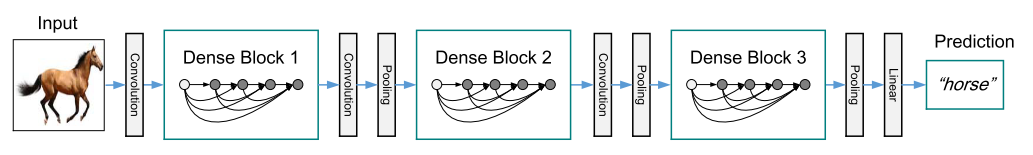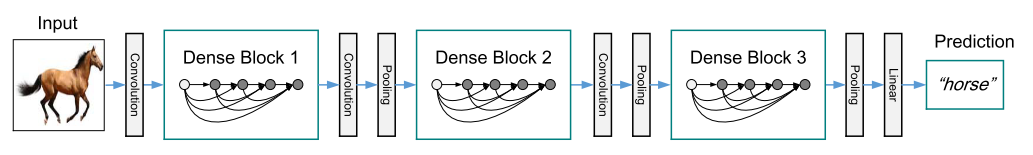

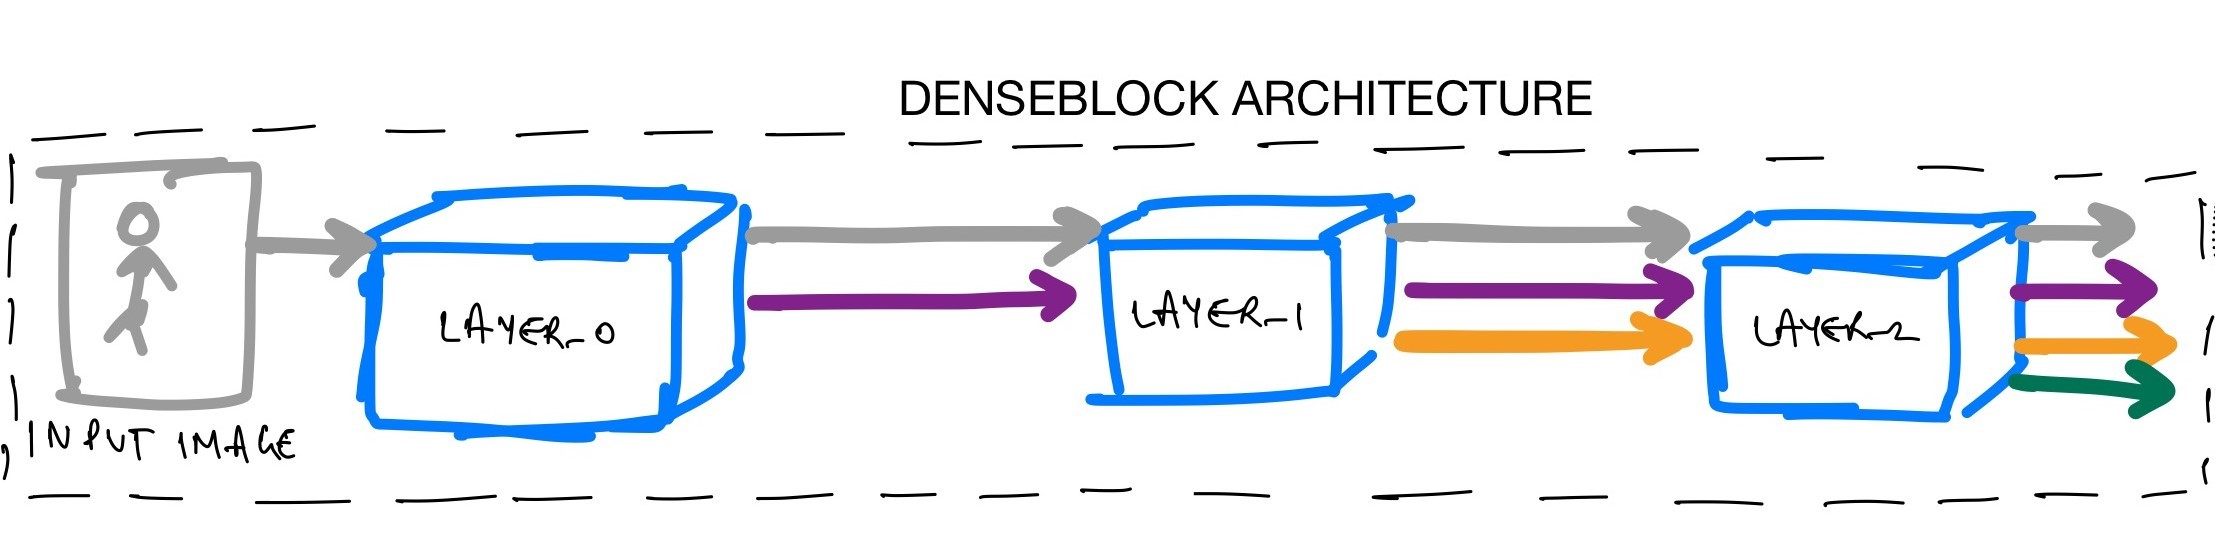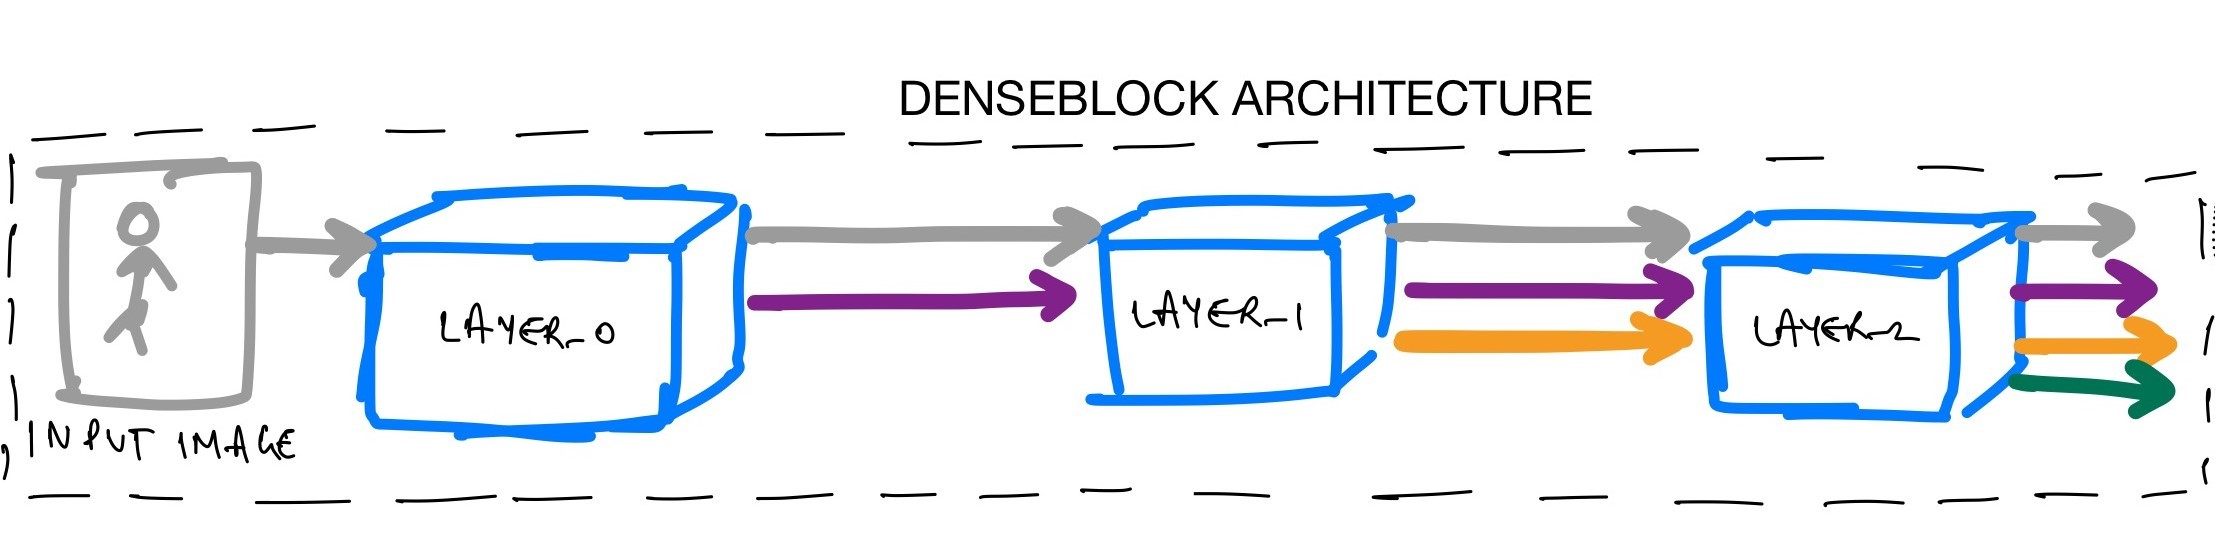

In [6]:
class Bottleneck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(Bottleneck, self).__init__()
        interChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)
        return out

class SingleLayer(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = torch.cat((x, out), 1)
        return out

class Transition(nn.Module):
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, growthRate, depth, reduction, nClasses, bottleneck):
        super(DenseNet, self).__init__()

        nDenseBlocks = (depth-4) // 3
        if bottleneck:
            nDenseBlocks //= 2

        nChannels = 2*growthRate
        self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1,
                               bias=False)
        self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans1 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans2 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate

        self.bn1 = nn.BatchNorm2d(nChannels)
        self.fc = nn.Linear(nChannels, nClasses)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_dense(self, nChannels, growthRate, nDenseBlocks, bottleneck):
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(Bottleneck(nChannels, growthRate))
            else:
                layers.append(SingleLayer(nChannels, growthRate))
            nChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = F.avg_pool2d(F.relu(self.bn1(out)), 8)
        out = out.view(out.size(0), -1)  # Flatten the output
        out = self.fc(out)
        out = F.log_softmax(out, dim=1)  # Use dim=1 here
        return out


In [7]:
import math
model = DenseNet(growthRate=12, depth=100, reduction=0.5, nClasses=10, bottleneck=True).to(device)

In [8]:
!pip install torchview

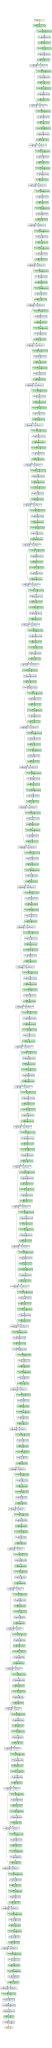

In [9]:
from torchview import draw_graph
model_graph = draw_graph(model, torch.zeros(1, 3, 32, 32))
model_graph.visual_graph

### Training the network

In [10]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [11]:
def accuracy(output, labels):
    predClassId = torch.argmax(output, dim=1)
    return (predClassId == labels).float().mean().item()

def evaluate(model, dl, loss_func):
    model.eval()
    with torch.no_grad():
        batch_losses, batch_accs = [], []

        for images, labels in dl:
            out = model(images)
            loss = loss_func(out, labels)
            batch_losses.append(loss)

            # Calculate accuracy
            acc = accuracy(out, labels)
            batch_accs.append(acc)

        val_loss = torch.stack(batch_losses).mean().item()
        val_acc = torch.tensor(batch_accs).mean().item()
        return val_loss, val_acc

def train(model, train_dl, val_dl, epochs, max_lr, loss_function, optimizer_class):
    model.to(device)  # Move model to the appropriate device
    optimizer = optimizer_class(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    early_stopper = EarlyStopper(patience=3, min_delta=10)

    results = []

    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []

        for images, labels in train_dl:  # for every batch
            optimizer.zero_grad()
            out = model(images)
            loss = loss_function(out, labels)
            train_loss.append(loss)
            loss.backward()  # delta loss/delta_model_parameters
            optimizer.step()
            lrs.append(optimizer.param_groups[0]['lr'])
        
        scheduler.step()

        epoch_train_loss = torch.stack(train_loss).mean().item()

        # Evaluate on validation data
        val_loss, val_acc = evaluate(model, val_dl, loss_function)
        if early_stopper.early_stop(val_loss):
            break

        # Store results
        results.append({'avg_train_loss': epoch_train_loss, 'avg_val_loss': val_loss, 'avg_val_acc': val_acc, 'lrs': lrs})
        if (epoch + 1) % 20 == 0:
            torch.save(model.state_dict(), 'model.pth')  # Overwrite the same file
            print(f'Model saved after epoch {epoch + 1}')

        # Print progress for each epoch
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Training Loss: {epoch_train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}\n")

    return results

In [12]:
epochs = 300
max_lr = 1e-2
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD

In [13]:
results = train(model, train_dl, val_dl, epochs, max_lr, loss_func, optimizer)

Epoch [1/300]
Training Loss: 1.6439
Validation Loss: 1.3931
Validation Accuracy: 0.4934

Epoch [2/300]
Training Loss: 1.2336
Validation Loss: 1.1068
Validation Accuracy: 0.6070

Epoch [3/300]
Training Loss: 1.0444
Validation Loss: 1.0180
Validation Accuracy: 0.6460

Epoch [4/300]
Training Loss: 0.9202
Validation Loss: 0.8915
Validation Accuracy: 0.6887

Epoch [5/300]
Training Loss: 0.8302
Validation Loss: 0.7499
Validation Accuracy: 0.7415

Epoch [6/300]
Training Loss: 0.7517
Validation Loss: 0.7574
Validation Accuracy: 0.7446

Epoch [7/300]
Training Loss: 0.6794
Validation Loss: 0.7562
Validation Accuracy: 0.7377

Epoch [8/300]
Training Loss: 0.6309
Validation Loss: 0.6381
Validation Accuracy: 0.7822

Epoch [9/300]
Training Loss: 0.5888
Validation Loss: 0.6037
Validation Accuracy: 0.7932

Epoch [10/300]
Training Loss: 0.5477
Validation Loss: 0.5848
Validation Accuracy: 0.7990

Epoch [11/300]
Training Loss: 0.5230
Validation Loss: 0.5386
Validation Accuracy: 0.8222

Epoch [12/300]
Trai

In [14]:
torch.save(model, 'modeldense.pth')

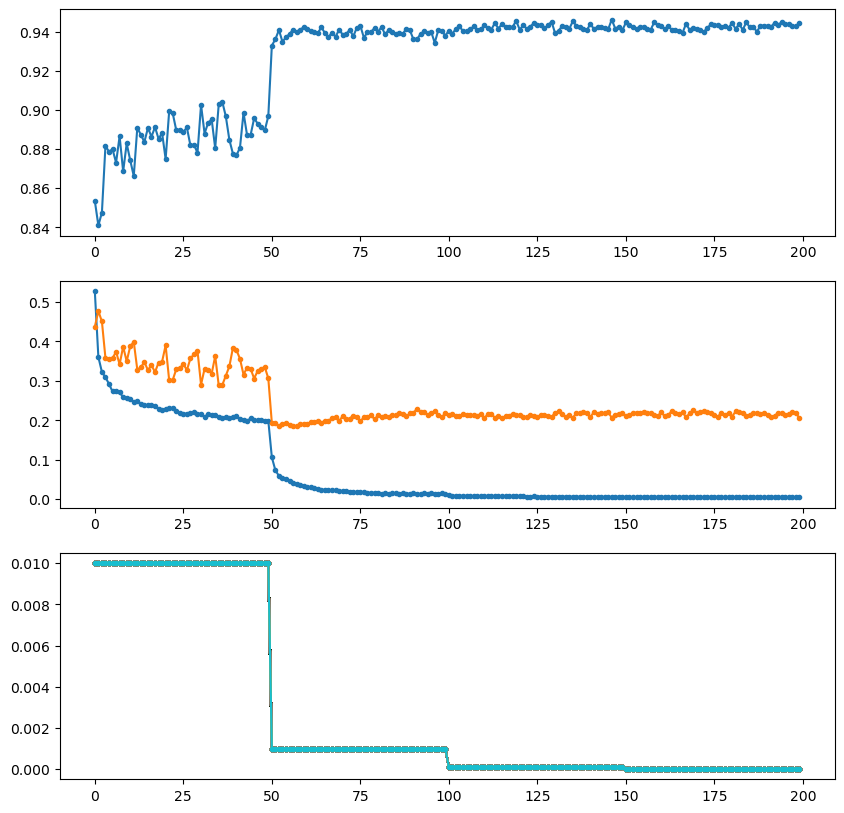

In [16]:
import matplotlib.pyplot as plt

def plot(results, pairs):
    fig, axes = plt.subplots(len(pairs), figsize=(10, 10))  # Adjust height for multiple plots
    for i, pair in enumerate(pairs):
        for title, graphs in pair.items():
            axes[i].set_title = title
            axes[i].legend = graphs
            for graph in graphs:
                axes[i].plot([result[graph] for result in results],".-")

# Example input
plot(results, [{"Accuracies vs epochs": ["avg_val_acc"]},
               {"Losses vs epochs": ["avg_train_loss", "avg_val_loss"]},
               {"Learning rate vs Batches": ["lrs"]}])


In [17]:
_ , val_acc = evaluate(model,test_dl,loss_func)
print(val_acc)

0.9396964907646179
